In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf

In [39]:
X_train = np.load(os.path.join('assets', 'X_train_surge_new.npz'))
Y_train = pd.read_csv(os.path.join('assets', 'Y_train_surge.csv'))
X_test = np.load(os.path.join('assets', 'X_test_surge_new.npz'))

In [58]:
x_surge1 = X_train['surge1_input']  # (5599, 10)
x_surge2 = X_train['surge2_input']  # (5599, 10)
xt_surge1 = X_train['t_surge1_input']  # (5599, 10)

x_slp = X_train['slp']       # (5599, 40, 41, 41)
x_slp = x_slp[:, ::4, :, :]  # (5599, 10, 41, 41)

y_surge1 = np.array([Y_train[f'surge1_t{i}'] for i in range(10)]).T  # (5599, 10)
y_surge2 = np.array([Y_train[f'surge2_t{i}'] for i in range(10)]).T  # (5599, 10)

print(x_surge1.shape, y_surge1.shape)

(5599, 10) (5599, 10)


(5599, 10) (5599, 10)
[[-0.14981814  0.00063871  0.10236663  0.02261483  0.01531486  0.00568334
  -0.001881    0.00461062  0.01889685  0.02816496]
 [-0.15107161 -0.01027678  0.04608165  0.09120235 -0.00030776  0.02249726
  -0.0125522   0.05383594 -0.05028827  0.04737186]
 [ 0.08455505 -0.22801633 -0.00641082  0.04651594  0.05137723  0.0116617
   0.02075504  0.04238351 -0.03739752  0.05749848]
 [ 0.1631526  -0.07426305 -0.23776847  0.04526302  0.0167523   0.09873864
  -0.00916593  0.05141886 -0.03342936  0.03299379]
 [ 0.11294852  0.01188961 -0.03214568 -0.19812067 -0.01564682  0.05780366
   0.04671129  0.02829268 -0.00726769  0.05612405]
 [ 0.05686434  0.02472312  0.10061774 -0.05955357 -0.24890906  0.0291393
   0.02202503  0.13238847 -0.04082143  0.04784437]
 [ 0.10344479 -0.02940871  0.0455803   0.05273439 -0.04258403 -0.23331866
   0.00120863  0.1083005  -0.00764997  0.07158063]
 [ 0.06642198  0.01371574 -0.01928088  0.05846035  0.09735841 -0.09584505
  -0.22988737  0.06433088 -0.02

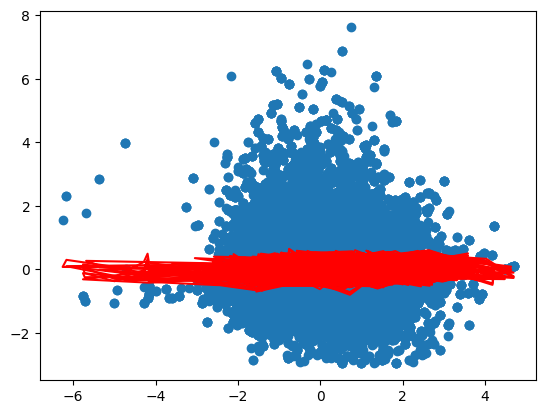

In [85]:
from sklearn.linear_model import LinearRegression

#créer un objet reg lin
modeleReg=LinearRegression()

#créer y et X
list_var=X_train.files

y=x_surge1
X=x_surge2
print(X.shape, y.shape)

modeleReg.fit(X,y)
modeleReg.score(X,y)

predictions=modeleReg.predict(X)
plt.scatter(X,y)
plt.plot(X,predictions,c='r')
print(modeleReg.coef_)


In [5]:
# create input data (each input is a tuple of (surge1, surge2, slp))
x_slp_flat = x_slp.reshape(x_slp.shape[0], -1)
print(x_surge1.shape, x_surge2.shape, x_slp_flat.shape)

input_data = np.concatenate([x_surge1, x_surge2, x_slp_flat], axis=1)
print(input_data.shape)

output_data = np.concatenate([y_surge1, y_surge2], axis=1)

# create time series data
def create_time_series_data(data, time_steps=10):
  X, Y = [], []
  for i in range(len(data) - time_steps):
    X.append(data[i: i + time_steps])
    Y.append(data[i + time_steps])
  return np.array(X), np.array(Y)

# create time series data
X, Y = create_time_series_data(input_data, time_steps=10)
print(X.shape, Y.shape)

# create train and test data
X_train, X_test = X[:5000], X[5000:]
Y_train, Y_test = Y[:5000], Y[5000:]

del X, Y, input_data, output_data, x_surge1, x_surge2, x_slp_flat, x_slp, y_surge1, y_surge2


(5599, 10) (5599, 10) (5599, 16810)
(5599, 16830)


: 

: 

In [ ]:
# create model
model = tf.keras.Sequential([
  tf.keras.layers.LSTM(128, input_shape=(10, 16830), return_sequences=True),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.Dense(20)
])

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()


In [ ]:
# fit model
hitsory = model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test))

# plot loss
plt.plot(hitsory.history['loss'], label='train')
plt.plot(hitsory.history['val_loss'], label='test')
plt.legend()
plt.show()


In [ ]:
# make predictions
Y_pred = model.predict(X_test)

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score)
 
# plot predictions
plt.plot(Y_test[:, 0], label='actual')
plt.plot(Y_pred[:, 0], label='predicted')
plt.legend()
plt.show()

In [ ]:
import surge_prediction_metric as surge

# convert predictions to dataframe
Y_pred_df = pd.DataFrame(Y_pred, columns=[f'surge1_t{i}' for i in range(10)] + [f'surge2_t{i}' for i in range(10)])
Y_true_df = pd.DataFrame(Y_test, columns=[f'surge1_t{i}' for i in range(10)] + [f'surge2_t{i}' for i in range(10)])

s1 = surge.surge_prediction_metric(Y_true_df[:10], Y_pred_df[:10])
s2 = surge.surge_prediction_metric(Y_true_df[10:], Y_pred_df[10:])
print(s1, s2)